In [53]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from itertools import combinations
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


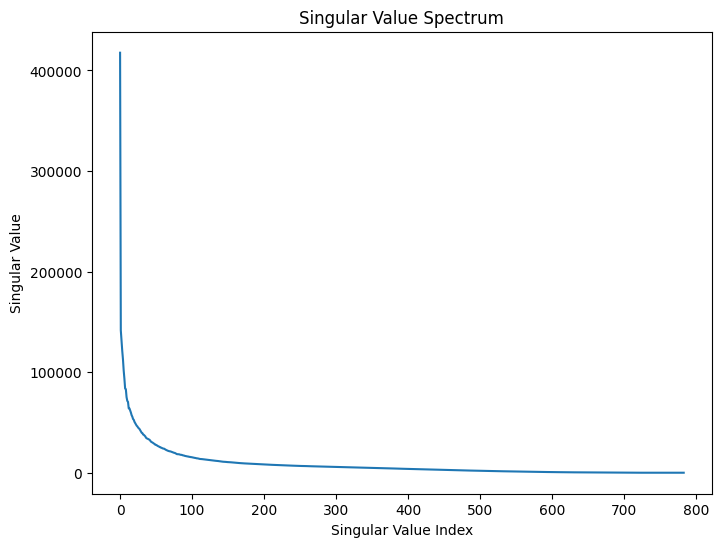

Total percentage of variance captured by the first 50 modes: 89.528712


In [57]:
# Reshape the images into column vectors
X = X.T
# Compute the SVD of the data matrix
U, S, V = np.linalg.svd(X, full_matrices=False)
# Plot the singular value spectrum
plt.figure(figsize=(8,6))
plt.plot(S)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum')
plt.show()
# Calculate total percentage of variance
n_modes = 50
variance_captured = [(S[i]**2 / np.sum(S**2)) * 100 for i in range(n_modes)]
print("Total percentage of variance captured by the first 50 modes: %f" %np.sum(variance_captured))

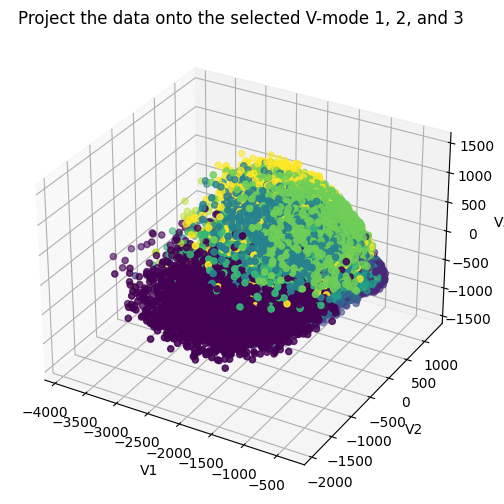

In [113]:
from mpl_toolkits.mplot3d import Axes3D
# Select three columns of V
V_selected = U[:, [0, 1, 2]]

# Project the data onto the selected V-modes
x_projected = np.dot(V_selected.T, X)

# Create a 3D scatter plot with colored points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_projected[0,:], x_projected[1,:], x_projected[2,:], c=y.astype(int))
ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('V3')
ax.set_title('Project the data onto the selected V-mode 1, 2, and 3')
plt.show()

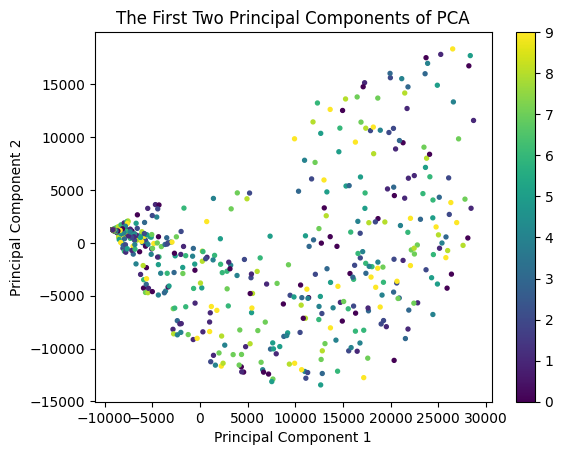

In [118]:
from sklearn.decomposition import PCA
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Plot the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mnist.target[:X_pca.shape[0]].astype(int), s=8)
plt.colorbar()
plt.title('The First Two Principal Components of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [62]:
# Calculate the cumulative sum of the explained variance ratios
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Print the variance captured by the first 50 components
print("Variance captured by the first 50 components:", cumulative_variance[49])

Variance captured by the first 50 components: 0.8741628170464028


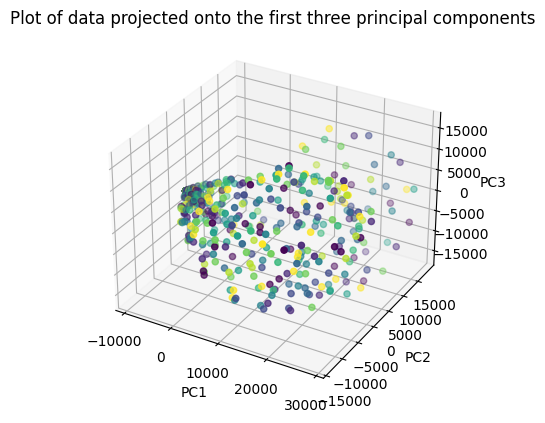

In [116]:
# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=mnist.target[:X_pca.shape[0]].astype(int), s=20)

# Set the labels and limits of the plot
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Plot of data projected onto the first three principal components')

plt.show()

In [103]:
# Project the data onto 50 modes PCA space
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [104]:
# Create a function to train and test classifiers on digit pairs
def test_digit_pairs(digit_pairs, classifier):
    accuracy_scores = []
    
    for digit_pair in digit_pairs:
        # Get the indices for the current digit pair
        digit_indices = ((y_train == digit_pair[0]) | (y_train == digit_pair[1]))

        # Create the feature and target datasets for the current digit pair
        X_pair_train = X_train_pca[digit_indices]
        y_pair_train = y_train[digit_indices]
        X_pair_test = X_test_pca[((y_test == digit_pair[0]) | (y_test == digit_pair[1]))]
        y_pair_test = y_test[((y_test == digit_pair[0]) | (y_test == digit_pair[1]))]

        # Train the classifier on the training data
        clf = classifier
        clf.fit(X_pair_train, y_pair_train)

        # Predict the labels of the test data
        y_pred = clf.predict(X_pair_test)

        # Calculate the accuracy of the classifier
        accuracy = accuracy_score(y_pair_test, y_pred)

        # Append the accuracy to the list of accuracy scores
        accuracy_scores.append(accuracy)

    # Calculate the average accuracy for all digit pairs
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    print(f"Average accuracy for all digit pairs: {avg_accuracy:.5f}")

    # Find the pair with the lowest accuracy
    most_difficult_pair = digit_pairs[np.argmin(accuracy_scores)]
    lowest_accuracy = min(accuracy_scores)
    print(f"The most difficult pair to separate is {most_difficult_pair} with an accuracy of {lowest_accuracy:.5f}.")

    # Find the pair with the highest accuracy
    least_difficult_pair = digit_pairs[np.argmax(accuracy_scores)]
    highest_accuracy = max(accuracy_scores)
    print(f"The least difficult pair to separate is {least_difficult_pair} with an accuracy of {highest_accuracy:.5f}.")
# Test the LDA classifier on all digit pairs
lda_pairs = list(combinations(np.unique(y), 2))
lda_classifier = LDA()
print("LDA")
test_digit_pairs(lda_pairs, lda_classifier)


LDA
Average accuracy for all digit pairs: 0.98090
The most difficult pair to separate is (3, 5) with an accuracy of 0.94463.
The least difficult pair to separate is (6, 9) with an accuracy of 0.99720.


In [102]:
# Test the SVM classifier on all digit pairs using 50 modes PCA
svm_pairs = list(combinations(range(10), 2))
svm_classifier = SVC()
print("SVM")
test_digit_pairs(svm_pairs, svm_classifier)

# Test the decision tree classifier on all digit pairs
dt_pairs = list(combinations(range(10), 2))
dt_classifier = DecisionTreeClassifier(random_state=42)
print("Decision Tree")
test_digit_pairs(dt_pairs, dt_classifier)

SVM
Average accuracy for all digit pairs: 0.99714
The most difficult pair to separate is (4, 9) with an accuracy of 0.99103.
The least difficult pair to separate is (1, 4) with an accuracy of 1.00000.
Decision Tree
Average accuracy for all digit pairs: 0.96731
The most difficult pair to separate is (4, 9) with an accuracy of 0.89164.
The least difficult pair to separate is (0, 1) with an accuracy of 0.99536.


In [106]:
# Test the classifiers on LDA classifier's most and least difficult pair to separate
two_digit_pairs = [(3, 5), (6, 9)]
print("SVM")
test_digit_pairs(two_digit_pairs, svm_classifier)
print("Decision Tree")
test_digit_pairs(two_digit_pairs, dt_classifier)
print("LDA")
test_digit_pairs(two_digit_pairs, lda_classifier)


SVM
Average accuracy for all digit pairs: 0.99645
The most difficult pair to separate is (3, 5) with an accuracy of 0.99360.
The least difficult pair to separate is (6, 9) with an accuracy of 0.99930.
Decision Tree
Average accuracy for all digit pairs: 0.95869
The most difficult pair to separate is (3, 5) with an accuracy of 0.93070.
The least difficult pair to separate is (6, 9) with an accuracy of 0.98668.
LDA
Average accuracy for all digit pairs: 0.97091
The most difficult pair to separate is (3, 5) with an accuracy of 0.94463.
The least difficult pair to separate is (6, 9) with an accuracy of 0.99720.


In [119]:
# Define the digits to include in the classification task
digits = [2, 3, 5]

# Extract the samples for the selected digits from the training data
X_train_digits = X_train[np.isin(y_train, digits)]
y_train_digits = y_train[np.isin(y_train, digits)]

# Train the LDA classifier on the selected training samples
lda = LDA()
lda.fit(X_train_digits, y_train_digits)

# Extract the test samples for the selected digits
X_test_digits = X_test[np.isin(y_test, digits)]
y_test_digits = y_test[np.isin(y_test, digits)]

# Make predictions on the test data
y_pred = lda.predict(X_test_digits)

# Evaluate the performance of the model
acc = accuracy_score(y_test_digits, y_pred)

# Print the results
print(f"Selected digits: {digits}")
print(f"Accuracy: {acc}")

Selected digits: [2, 3, 5]
Accuracy: 0.9319643740722414
